<a href="https://colab.research.google.com/github/lnpetrova/comp_ling/blob/master/ML_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импорты**

In [2]:
!pip3 install pandas scikit-learn matplotlib

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from string import punctuation, digits, ascii_lowercase
punct = punctuation+'«»—…“”*№–'

In [5]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def make_plot(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['f1'])
  plt.plot(model.history.history['val_f1'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# **Данные**

In [1]:
!wget https://www.dropbox.com/s/kztcxbki36m8yrn/quora.csv?dl=0

--2020-06-28 15:42:46--  https://www.dropbox.com/s/kztcxbki36m8yrn/quora.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kztcxbki36m8yrn/quora.csv [following]
--2020-06-28 15:42:47--  https://www.dropbox.com/s/raw/kztcxbki36m8yrn/quora.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5fe3f3f3f1d4e87e56dac4efb9.dl.dropboxusercontent.com/cd/0/inline/A6hX0LvAQ8OCIJ2e9HnTb9VSAbhAKLzAmDLyFK2-R48NmU98sQKoz4yZ1eIZkefgBRLQRtI03YQNzrY1Dt8vQEgTx6rFnePXgf_yvIoUyRrO4XegdJa9qZoIjBEkz5WVTwc/file# [following]
--2020-06-28 15:42:47--  https://uc5fe3f3f3f1d4e87e56dac4efb9.dl.dropboxusercontent.com/cd/0/inline/A6hX0LvAQ8OCIJ2e9HnTb9VSAbhAKLzAmDLyFK2-R48NmU98sQKoz4yZ1eIZkefgBRLQRtI03YQNzrY1Dt8vQEgTx6rFnePXgf_yvIoUyRrO4XegdJa9qZ

In [8]:
quora = pd.read_csv('quora.csv?dl=0')

In [9]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


**Посимвольная токенизация**

In [86]:
def char_tokenize(text):
    chars = list(text)
    return chars

In [87]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(char_tokenize(text))

In [88]:
char2id = {'UNK':1, 'PAD':0}

for char in vocab:
    char2id[char] = len(char2id)

In [89]:
id2char = {i:char for char, i in char2id.items()}

In [90]:
X = []

for text in quora.question_text:
    chars = char_tokenize(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [91]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 5)

In [92]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [93]:
y = quora.target.values

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# **Модель1**

С другими активаторами модель показывает результаты намного хуже

In [95]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [99]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=50)(inputs, )

all_drops = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
all_drops.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
all_drops.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
all_drops.append(drop3)

concat = tf.keras.layers.Concatenate()(all_drops)
dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [100]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1024,
          epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
893/893 [==============================] - ETA: 0s - loss: 0.2350 - f1: 1.7726e-04
Epoch 00001: val_f1 did not improve from 0.85167
893/893 [==============================] - 42s 47ms/step - loss: 0.2350 - f1: 1.7726e-04 - val_loss: 0.2154 - val_f1: 0.0000e+00
Epoch 2/10
893/893 [==============================] - ETA: 0s - loss: 0.2128 - f1: 0.1163
Epoch 00002: val_f1 did not improve from 0.85167
893/893 [==============================] - 41s 46ms/step - loss: 0.2128 - f1: 0.1163 - val_loss: 0.2110 - val_f1: 0.4900
Epoch 3/10
892/893 [============================>.] - ETA: 0s - loss: 0.2084 - f1: 0.5058
Epoch 00003: val_f1 did not improve from 0.85167
893/893 [==============================] - 41s 46ms/step - loss: 0.2084 - f1: 0.5056 - val_loss: 0.2072 - val_f1: 0.5756
Epoch 4/10
892/893 [============================>.] - ETA: 0s - loss: 0.2064 - f1: 0.5914
Epoch 00004: val_f1 did not improve from 0.85167
893/893 [==============================] - 41s 46ms/step - loss: 0.20

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


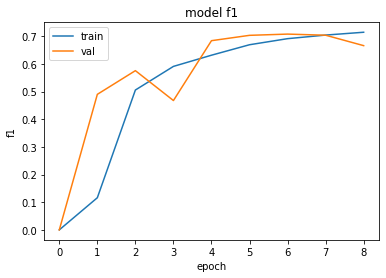

In [101]:
make_plot(model)

**Попробуем добавить паддинги**

In [96]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=100)(inputs, )

all_drops = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
all_drops.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
all_drops.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
all_drops.append(drop3)

concat = tf.keras.layers.Concatenate()(all_drops)
dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [97]:
model1.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1024,
          epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
893/893 [==============================] - ETA: 0s - loss: 0.2250 - f1: 0.0535
Epoch 00001: val_f1 improved from -inf to 0.58175, saving model to model.weights
893/893 [==============================] - 79s 88ms/step - loss: 0.2250 - f1: 0.0535 - val_loss: 0.2092 - val_f1: 0.5817
Epoch 2/10
893/893 [==============================] - ETA: 0s - loss: 0.2066 - f1: 0.6681
Epoch 00002: val_f1 improved from 0.58175 to 0.72287, saving model to model.weights
893/893 [==============================] - 77s 87ms/step - loss: 0.2066 - f1: 0.6681 - val_loss: 0.2048 - val_f1: 0.7229
Epoch 3/10
893/893 [==============================] - ETA: 0s - loss: 0.2031 - f1: 0.7760
Epoch 00003: val_f1 improved from 0.72287 to 0.72606, saving model to model.weights
893/893 [==============================] - 77s 87ms/step - loss: 0.2031 - f1: 0.7760 - val_loss: 0.2023 - val_f1: 0.7261
Epoch 4/10
893/893 [==============================] - ETA: 0s - loss: 0.2012 - f1: 0.8169
Epoch 00004: val_f1 improved

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


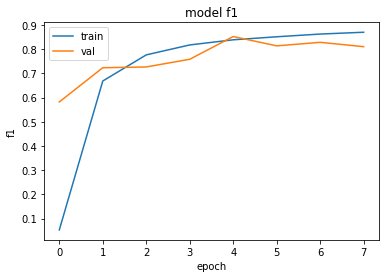

In [98]:
make_plot(model1)

Как видно, модель с паддингами показала лучший результат, дальше будем использовать.

**Приведем к нижнему регистру**

In [102]:
def char_tokenize(text):
    chars = list(text.lower())
    return chars

In [103]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(char_tokenize(text))

In [104]:
char2id = {'UNK':1, 'PAD':0}

for char in vocab:
    char2id[char] = len(char2id)

In [105]:
id2char = {i:char for char, i in char2id.items()}

In [106]:
X = []

for text in quora.question_text:
    chars = char_tokenize(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [107]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [108]:
y = quora.target.values

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# **Модель2**

In [110]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=100)(inputs, )

all_drops = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
all_drops.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding = 'same', activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
all_drops.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding = 'same', activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
all_drops.append(drop3)

concat = tf.keras.layers.Concatenate()(all_drops)
dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [111]:
model2.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1024,
          epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
893/893 [==============================] - ETA: 0s - loss: 0.2255 - f1: 0.0043
Epoch 00001: val_f1 did not improve from 0.85167
893/893 [==============================] - 78s 87ms/step - loss: 0.2255 - f1: 0.0043 - val_loss: 0.2117 - val_f1: 0.0998
Epoch 2/10
893/893 [==============================] - ETA: 0s - loss: 0.2084 - f1: 0.5494
Epoch 00002: val_f1 did not improve from 0.85167
893/893 [==============================] - 77s 87ms/step - loss: 0.2084 - f1: 0.5494 - val_loss: 0.2052 - val_f1: 0.7027
Epoch 3/10
893/893 [==============================] - ETA: 0s - loss: 0.2044 - f1: 0.7503
Epoch 00003: val_f1 did not improve from 0.85167
893/893 [==============================] - 77s 87ms/step - loss: 0.2044 - f1: 0.7503 - val_loss: 0.2027 - val_f1: 0.8090
Epoch 4/10
893/893 [==============================] - ETA: 0s - loss: 0.2023 - f1: 0.7954
Epoch 00004: val_f1 did not improve from 0.85167
893/893 [==============================] - 77s 87ms/step - loss: 0.2023 - f1: 0.7

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


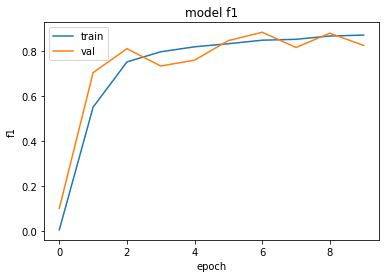

In [112]:
make_plot(model2)

После приведения текста в нижний регистр f1немного возросла, поэтому такая нормализация будет не лишней.